# Настраиваем окружение

In [1]:
from rich import print
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

True

# Подключаем GigaChat

In [2]:
from langchain_gigachat import GigaChat

llm = GigaChat(model="GigaChat-2-Max", profanity_check=False, top_p=0)
print(llm.invoke("Кто тебя сделал?").content)

Меня создала компания Sber в России в 2023 году.

# Создаем ReAact агента с возможностью поиска в интернете

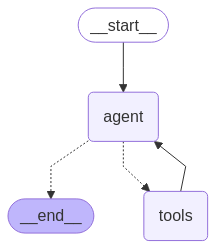

In [171]:
from langgraph.prebuilt import create_react_agent
from langchain_community.tools import DuckDuckGoSearchRun # !pip install duckduckgo_search

search_tool = DuckDuckGoSearchRun()

agent = create_react_agent(llm, tools=[search_tool], prompt="Ты полезный ассистент")
agent

In [68]:
inputs = {"messages": [("user", "Какая самая дорогая компания в мире на сегодня?")]}
messages = agent.invoke(inputs)['messages']

In [69]:
print(messages[-1].content)

На данный момент самой дорогой компанией в мире является **NVIDIA**, чья рыночная капитализация превышает **$3,6 
трлн**. Однако стоит учитывать, что такие рейтинги могут изменяться ежедневно из-за колебаний цен акций на бирже. 
Ранее лидерами были **Apple** и **Microsoft**, но сейчас они занимают второе и третье места соответственно. Рейтинг
регулярно обновляется, поэтому для получения актуальной информации рекомендуется проверять последние новости или 
специализированные финансовые ресурсы.

## Изучим лог работы агента
Видно, что агент сначала сделал вызов функции, затем LLM обработала результат поиска и потом подготовила итоговый ответ для пользователя.

In [70]:
print(messages)

[
    HumanMessage(
        content='Какая самая дорогая компания в мире на сегодня?',
        additional_kwargs={},
        response_metadata={},
        id='69467c28-85b6-4f8c-b851-fd3cd314f2df'
    ),
    AIMessage(
        content='',
        additional_kwargs={
            'function_call': {
                'name': 'duckduckgo_search',
                'arguments': {'query': 'самая дорогая компания в мире на сегодня'}
            },
            'functions_state_id': '3cc42bd9-000d-44a2-8b0a-59df2dee03cb'
        },
        response_metadata={
            'token_usage': {
                'prompt_tokens': 105,
                'completion_tokens': 35,
                'total_tokens': 140,
                'precached_prompt_tokens': 2
            },
            'model_name': 'GigaChat-2-Max:2.0.28.02',
            'x_headers': {
                'x-request-id': '6ff44bfa-0f16-45d3-9c6a-40f5013f6f0a',
                'x-session-id': '32438b1f-7928-4c16-a54a-d3bf3931ce0e',
                'x-client-id': None
            },
            'finish_reason': 'function_call'
        },
        id='6ff44bfa-0f16-45d3-9c6a-40f5013f6f0a',
        tool_calls=[
            {
                'name': 'duckduckgo_search',
                'args': {'query': 'самая дорогая компания в мире на сегодня'},
                'id': '27f2524e-983f-464f-8362-22803049f87b',
                'type': 'tool_call'
            }
        ],
        usage_metadata={
            'output_tokens': 35,
            'input_tokens': 105,
            'total_tokens': 140,
            'input_token_details': {'cache_read': 2}
        }
    ),
    ToolMessage(
        content='Собрали самые дорогие компании по рыночной капитализации. Не забывайте, что этот список постоянно 
обновляется - данные актуальны на декабрь 2024. 1. Apple Inc. (AAPL) Apple остаётся лидером, предлагая 
инновационные устройства и укрепляя свою экосистему продуктов. 2. NVIDIA Corporation (NVDA) Акции Nvidia на прошлой
неделе достигли рекордного максимума, сделав производителя чипов первой компанией в истории, чья стоимость на 
фондовом рынке превысила 3,6 триллиона долларов. Рассказываем о рейтинге самых дорогих компаний в мире, месте 
Nvidia в нем и объясняем, какие действия, технологии и чипы компании в сфере искусственного интеллекта на это 
повлияли В 2025 году самой дорогой компанией в мире является Apple с рыночной капитализацией в 3.548 трлн долларов 
. На втором месте - Microsoft ($3.085 трлн). Третье место занимает NVIDIA с капитализацией 2.940 трлн долларов. 
Далее мы рассмотрим рейтинг десяти крупнейших компаний в мире, отсортированных по рыночной капитализации. NVIDIA. 
Накануне акции Nvidia закрылись ростом на 2,84% на отметке $139,91 за штуку. В результате рыночная стоимость 
компании достигла $3,43 трлн. Капитализация производителя Iphone по итогам...',
        name='duckduckgo_search',
        id='c156b177-7e68-46a1-9537-425718468b51',
        tool_call_id='27f2524e-983f-464f-8362-22803049f87b'
    ),
    AIMessage(
        content='На данный момент самой дорогой компанией в мире является **NVIDIA**, чья рыночная капитализация 
превышает **$3,6 трлн**. Однако стоит учитывать, что такие рейтинги могут изменяться ежедневно из-за колебаний цен 
акций на бирже. Ранее лидерами были **Apple** и **Microsoft**, но сейчас они занимают второе и третье места 
соответственно. Рейтинг регулярно обновляется, поэтому для получения актуальной информации рекомендуется проверять 
последние новости или специализированные финансовые ресурсы.',
        additional_kwargs={'functions_state_id': '9205e0af-0b58-4620-8fe5-579a8a3b14d8'},
        response_metadata={
            'token_usage': {
                'prompt_tokens': 300,
                'completion_tokens': 92,
                'total_tokens': 392,
                'precached_prompt_tokens': 140
            },
            'model_name': 'GigaChat-2-Max:2.0.28.02',
            'x_headers': {
                'x-request-id': '72a9f523-e452-4664-b118-5a012209c999',


# Агент для заполнения LeanCanvas

## Structured output - наивный подход

In [231]:
from pydantic import BaseModel
from typing import Optional

class LeanCanvasResult(BaseModel):
    """
    Представляет результат генерации Lean Canvas.
    Каждое поле соответствует разделу Lean Canvas.
    """
    problem: str  # Проблема, которую пытается решить продукт или услуга.
    solution: str  # Краткое описание предлагаемого решения.
    key_metrics: str  # Ключевые показатели, которые необходимо измерять для отслеживания прогресса.
    unique_value_proposition: str  # Единое, ясное и убедительное сообщение, объясняющее, почему вы отличаетесь от других и почему стоит покупать именно у вас.
    unfair_advantage: str  # То, что конкуренты не могут легко скопировать или купить.
    channels: str  # Пути охвата ваших клиентских сегментов.
    customer_segments: str  # Целевая аудитория или группы людей, которых вы пытаетесь охватить.
    cost_structure: str  # Основные затраты, связанные с ведением бизнеса.
    revenue_streams: str  # Как бизнес будет зарабатывать деньги.

In [233]:
structured_llm = llm.with_structured_output(LeanCanvasResult)

prompt = "Создайте Lean Canvas для онлайн-платформы изучения языков, которая связывает изучающих язык с носителями языка."

print(structured_llm.invoke(prompt))

LeanCanvasResult(
    problem='Трудности в изучении языка самостоятельно, нехватка практики общения с носителями языка, отсутствие 
мотивации и дисциплины, высокие цены на традиционные курсы.  ",\n    ',
    solution='Онлайн-платформа, связывающая изучающих язык с носителями языка для практики общения, доступ к 
учебным материалам и ресурсам, возможность выбора удобного графика и формата занятий.  ",\n    ',
    key_metrics='Количество активных пользователей, количество проведенных уроков, уровень удовлетворенности 
пользователей, коэффициент удержания пользователей, доход на одного пользователя.  ",\n    ',
    unique_value_proposition='Изучение языка с носителями в удобном формате и по доступной цене, возможность 
практики общения в реальном времени, доступ к учебным материалам и ресурсам, мотивация и поддержка от сообщества 
пользователей.  "\n}',
    unfair_advantage='Уникальная система подбора партнеров по языку, основанная на интересах и целях пользователей,
доступ к большому количеству носителей языка из разных стран, возможность бесплатного общения в рамках платформы.  
",\n    ',
    channels='Платформы социальных сетей, реферальные программы, контент-маркетинг, SEO, партнерские программы с 
языковыми школами и университетами.  ",\n    ',
    customer_segments='Изучающие иностранные языки, студенты, путешественники, эмигранты, профессионалы, желающие 
улучшить свои языковые навыки.  ",\n    ',
    cost_structure='Разработка и поддержка платформы, маркетинг и привлечение пользователей, оплата труда 
модераторов и администраторов, юридические и бухгалтерские расходы.  ",\n    ',
    revenue_streams='Подписка на платформу, комиссия с уроков, продажа дополнительных материалов и услуг, реклама и
спонсорство.  ",\n    '
)

# Заполняем по шагам

## Стейт графа
Глобальное пространство данных в котором идет работа с графом

In [26]:
from langgraph.graph import END, START, StateGraph
from typing_extensions import TypedDict, Annotated

class LeanGraphState(TypedDict):
    main_task: Annotated[str, "Основная задача от пользователя"]
    competitors_analysis: Annotated[str, "Анализ конкурентов"]
    feedback: Annotated[str, "Фидбек от пользователя. Обязательно учитывай его в своих ответах!"]

    # Lean Canvas
    problem: Annotated[str, "Проблема, которую пытается решить продукт или услуга."]
    solution: Annotated[str, "Краткое описание предлагаемого решения."]
    key_metrics: Annotated[str, "Ключевые показатели, которые необходимо измерять для отслеживания прогресса."]
    unique_value_proposition: Annotated[str, "Единое, ясное и убедительное сообщение, объясняющее, почему вы отличаетесь от других и почему стоит покупать именно у вас."]
    unfair_advantage: Annotated[str, "То, что конкуренты не могут легко скопировать или купить."]
    channels: Annotated[str, "Пути охвата ваших клиентских сегментов."]
    customer_segments: Annotated[str, "Целевая аудитория или группы людей, которых вы пытаетесь охватить."]
    cost_structure: Annotated[str, "Основные затраты, связанные с ведением бизнеса."]
    revenue_streams: Annotated[str, "Как бизнес будет зарабатывать деньги."]


def state_to_string(state: LeanGraphState) -> str:
    """
    Преобразует состояние в строку для отображения.
    """
    result = []
    for field, annotation in LeanGraphState.__annotations__.items():
        value = state.get(field, "")
        if value:
            # annotation is typing.Annotated[type, description]
            if hasattr(annotation, "__metadata__") and annotation.__metadata__:
                desc = annotation.__metadata__[0]
            else:
                desc = ""
            result.append(f"{desc} ({field}): {value}")
    return "\n".join(result)


# Основные шаги генерации

In [55]:
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate
from langgraph.types import interrupt

def ask_llm(state: LeanGraphState, question: str):
    TEMPLATE = """
    Ты - эксперт в области стартапов и Lean Canvas. Твоя задача - помочь пользователю создать Lean Canvas для его задачи.
    Учитывай уже заполненные части таблицы Lean Canvas и главную задачу пользователя (main_task).
    
    Обязательно учитывай фидбек от пользователя (feedback), если он задан.
    <STATE>
    {state}
    </STATE>
    
    Ответь на вопрос: {question}
    Отвечай коротко, не более 1-2 коротких предложений и обязательно учти фидбек от пользователя (feedback), если он задан. Оформи ответ в виде буллетов.
    """
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", TEMPLATE)
    ])
    
    chain = prompt | llm | StrOutputParser()
    return chain.invoke({"state": state_to_string(state), "question": question})

def customer_segments(state: LeanGraphState):
    return {"customer_segments": ask_llm(state, "Кто ваши целевые клиенты?")}

def problem(state: LeanGraphState):
    return {"problem": ask_llm(state, "Какую проблему вы решаете?")}

def unique_value_proposition(state: LeanGraphState):
    return {"unique_value_proposition": ask_llm(state, "Какое уникальное предложение вы предлагаете?")}

def solution(state: LeanGraphState):
    return {"solution": ask_llm(state, "Какое решение вы предлагаете для этой проблемы?")}

def channels(state: LeanGraphState):
    return {"channels": ask_llm(state, "Какие каналы привлечения клиентов вы используете?")}

def revenue_streams(state: LeanGraphState):
    return {"revenue_streams": ask_llm(state, "Как вы планируете зарабатывать деньги?")}

def cost_structure(state: LeanGraphState):
    return {"cost_structure": ask_llm(state, "Какова структура ваших затрат?")}

def key_metrics(state: LeanGraphState):
    return {"key_metrics": ask_llm(state, "Какие ключевые показатели вы будете отслеживать?")}

def unfair_advantage(state: LeanGraphState):
    return {"unfair_advantage": ask_llm(state, "Какое ваше конкурентное преимущество?")}

# Агент проверки уникальности идеи
- Использует интернет для формирования действительно уникальных предложений
- Принимает решение - нужно ли генерировать новые идеи или можно продолжать генерацию
- Демонстрирует принцип handoff с помощью Command

In [56]:
from typing_extensions import Literal
from langgraph.types import Command
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser
from langchain_tavily import TavilySearch

class CompetitorsAnalysisResult(BaseModel):
    """Анализ конкурентов"""
    thoughts: str = Field(description="Мысли по поводу ответа")
    solution: str = Field(description="Какие конкуренты существуют и чем они отличаются от вашего продукта")
    is_unique: bool = Field(description="Уникально ли ваше предложение?")

COMPETITION_ANALYSIS_TEMPLATE = """Ты работаешь над таблицей Lean Canvas и тебе нужно проанализировать конкурентов.

Учитывай уже заполненные части таблицы Lean Canvas и главную задачу пользователя (main_task).
<STATE>
{state}
</STATE>

Результаты поиска по запросу "{unique_value_proposition}". Учитывай их, чтобы понять, уникальную ли идею ты придумал.
Если в поиске нет ничего похожего, значит идея вероятно уникальная.
<SEARCH_RESULTS>
{search_results}
</SEARCH_RESULTS>

Выведи только следующую информацию в формате JSON:
{format_instructions}"""

def check_unique(state: LeanGraphState) -> Command[Literal["4_solution", "3_unique_value_proposition"]]:
    parser = PydanticOutputParser(pydantic_object=CompetitorsAnalysisResult)
    prompt = ChatPromptTemplate.from_messages([
        ("system", COMPETITION_ANALYSIS_TEMPLATE)
    ]).partial(format_instructions=parser.get_format_instructions())
    
    search_results_text = TavilySearch().run(state["unique_value_proposition"])    
    
    chain = prompt | llm | parser
    res = chain.invoke(
        {
            "state": state_to_string(state),
            "unique_value_proposition": state["unique_value_proposition"],
            "search_results": search_results_text
        }
    )
    
    competitors_analysis = state.get("competitors_analysis", "") + "\n" + state["unique_value_proposition"] + " - " + res.solution
    
    if res.is_unique:
        # Если предложение уникально, переходим к следующему шагу
        return Command(
            update={"competitors_analysis": competitors_analysis.strip()},
            goto="4_solution",
        )
    else:
        # Если предложение не уникально, возвращаемся к шагу "3_unique_value_proposition"
        return Command(
            update={"competitors_analysis": competitors_analysis.strip()},
            goto="3_unique_value_proposition",
        )


# Фидбек от пользователя
- Human in the middle
- Interrupt

In [57]:
from typing import Literal, TypeAlias

RedirectStep: TypeAlias = Literal[
    "1_customer_segments",
    "2_problem",
    "3_unique_value_proposition",
    "4_solution",
    "5_channels",
    "6_revenue_streams",
    "7_cost_structure",
    "8_key_metrics",
    "9_unfair_advantage",
    "__end__"
]

class UserFeedback(BaseModel):
    """Анализ конкурентов"""
    feedback: str = Field(description="Фидебек пользователя, что надо исправить")
    next_step: RedirectStep = Field(description="Следующий шаг в Lean Canvas")
    is_done: bool = Field(description="Можно ли завершать создание Lean Canvas?")
    
FEEDBACK_TEMPLATE = """Ты работаешь над таблицей Lean Canvas. Ты уже сгенерировал версию Lean Canvas и получил фидбек от пользователя.
Тебе нужно разобраться фидбек и понять, как действовать дальше, заполнив таблицу с ответом.

Учитывай уже заполненные части таблицы Lean Canvas и главную задачу пользователя (main_task).
<STATE>
{state}
</STATE>

Вот фидбек пользователя на твою работу:
{feedback}

Извлеки из него данные для дальнейшей работы.
Выведи только следующую информацию в формате JSON:
{format_instructions}"""

def get_feedback(state: LeanGraphState) -> Command[RedirectStep]:
    feedback = interrupt("""Пожалуйста, дайте обратную связь по Lean Canvas. Если все хорошо, напишите 'Хорошо'. 
Если нужно что-то изменить, напишите, что именно и с какого шага начать.""")


    parser = PydanticOutputParser(pydantic_object=UserFeedback)
    prompt = ChatPromptTemplate.from_messages([
        ("system", FEEDBACK_TEMPLATE)
    ]).partial(format_instructions=parser.get_format_instructions())
    
  
    chain = prompt | llm | parser
    res = chain.invoke(
        {
            "state": state_to_string(state),
            "feedback": feedback,
        }
    )
    
    if res.is_done:
        return Command(update={}, goto=END)
    else:
        # Если предложение не уникально, возвращаемся к шагу "3_unique_value_proposition"
        return Command(
            update={"feedback": res.feedback},
            goto=res.next_step,
        )


# Сборка графа

In [58]:
from langgraph.checkpoint.memory import MemorySaver

graph = StateGraph(LeanGraphState)

graph.add_node("1_customer_segments", customer_segments)
graph.add_node("2_problem", problem)
graph.add_node("3_unique_value_proposition", unique_value_proposition)
graph.add_node("3.1_check_unique", check_unique)
graph.add_node("4_solution", solution)
graph.add_node("5_channels", channels)
graph.add_node("6_revenue_streams", revenue_streams)
graph.add_node("7_cost_structure", cost_structure)
graph.add_node("8_key_metrics", key_metrics)
graph.add_node("9_unfair_advantage", unfair_advantage)
graph.add_node("get_feedback", get_feedback)

graph.add_edge(START, "1_customer_segments")
graph.add_edge("1_customer_segments", "2_problem")
graph.add_edge("2_problem", "3_unique_value_proposition")
graph.add_edge("3_unique_value_proposition", "3.1_check_unique")
graph.add_edge("4_solution", "5_channels")
graph.add_edge("5_channels", "6_revenue_streams")
graph.add_edge("6_revenue_streams", "7_cost_structure")
graph.add_edge("7_cost_structure", "8_key_metrics")
graph.add_edge("8_key_metrics", "9_unfair_advantage")
graph.add_edge("9_unfair_advantage", "get_feedback")

memory = MemorySaver()
app = graph.compile(checkpointer=memory)

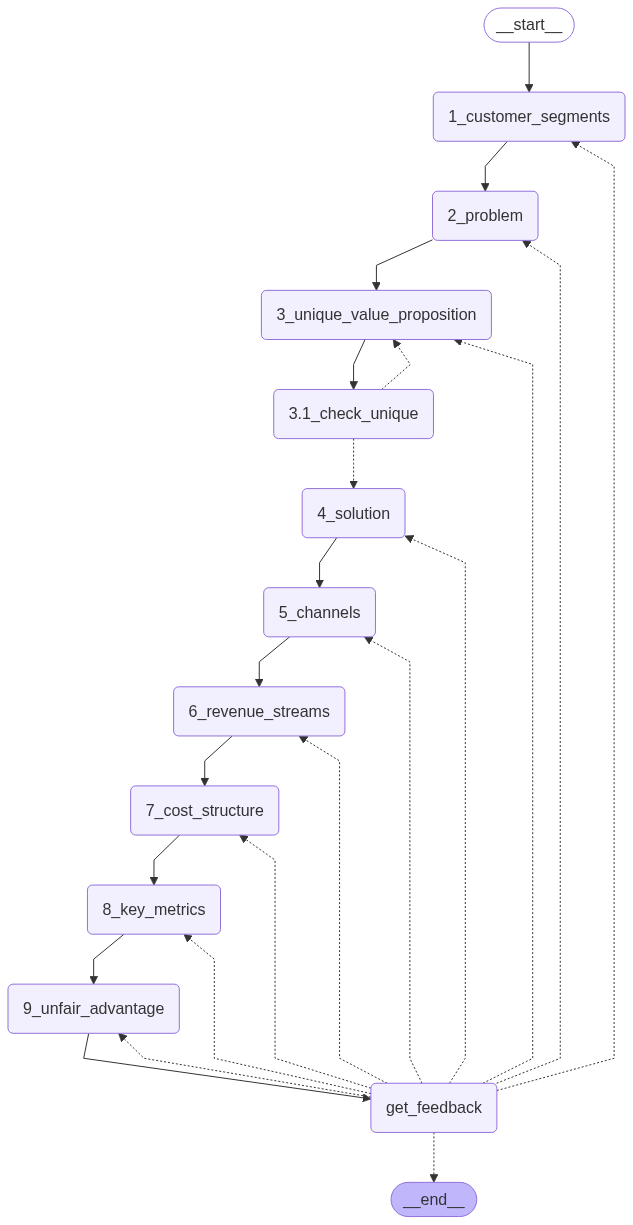

In [59]:
from utils import show_graph
show_graph(app)

In [60]:
import uuid

inputs = {"main_task": "Онлайн платформа для изучения английского языка с AI-агентами"}
conf = {"configurable": {"thread_id": str(uuid.uuid4())}}


for event in app.stream(inputs, config=conf):
  print(event)
  
while '__interrupt__' in event:
  print(f"Bot interrupted. {event['__interrupt__'][0].value}")
  user_input = input("User: ")
  for event in app.stream(Command(resume=user_input), config=conf):
    print(event)
        

{
    '1_customer_segments': {
        'customer_segments': '- Студенты и взрослые, изучающие английский язык самостоятельно  \n- Преподаватели 
иностранных языков, использующие современные технологии в обучении'
    }
}

{
    '2_problem': {
        'problem': '- Отсутствие эффективных интерактивных инструментов для самостоятельного изучения английского 
языка.  \n- Ограниченность традиционных методов обучения и нехватка персонализированного подхода.'
    }
}

{
    '3_unique_value_proposition': {
        'unique_value_proposition': '- Уникальная онлайн-платформа с AI-агентами для эффективного и увлекательного 
изучения английского языка.  \n- Персонализированные занятия и интерактивное взаимодействие для быстрого прогресса 
каждого ученика.'
    }
}

{
    '3.1_check_unique': {
        'competitors_analysis': '- Уникальная онлайн-платформа с AI-агентами для эффективного и увлекательного 
изучения английского языка.  \n- Персонализированные занятия и интерактивное взаимодействие для быстрого прогресса 
каждого ученика. - Конкуренты включают платформы типа SpeakEnglishAI, Vocalo.ai, ELSA Speak, Fluency и Bright AI. 
Эти сервисы предлагают различные подходы к изучению английского языка с использованием ИИ, однако они либо 
ориентированы на улучшение конкретных аспектов (например, произношения), либо предоставляют общий подход к обучению
языку. Ваше предложение отличается акцентом на уникальность платформы, использование AI-агентов и персонализацию 
занятий, что выделяет его среди существующих решений.'
    }
}

{
    '4_solution': {
        'solution': '- Онлайн-платформа с AI-агентами для эффективного и увлекательного изучения английского языка.
\n- Персонализированные занятия и интерактивное взаимодействие для быстрого прогресса каждого ученика.'
    }
}

{
    '5_channels': {
        'channels': '- Контекстная реклама и таргетинг в социальных сетях (Instagram, VKontakte).  \n- Партнерство 
с образовательными учреждениями и языческими школами.'
    }
}

{
    '6_revenue_streams': {
        'revenue_streams': '- Подписка на премиум-функциональность платформы.  \n- Продажа дополнительного 
образовательного контента и индивидуальных курсов.'
    }
}

{
    '7_cost_structure': {
        'cost_structure': '- Разработка и поддержка платформы  \n- Оплата услуг специалистов по искусственному 
интеллекту и разработке ПО  \n- Маркетинговые расходы на привлечение пользователей  \n- Поддержание инфраструктуры 
серверов и облачных сервисов'
    }
}

{
    '8_key_metrics': {
        'key_metrics': '- Количество активных пользователей ежемесячно (MAU)\n- Уровень удержания пользователей 
(Retention Rate)\n- Средняя продолжительность сессии на платформе\n- Число завершённых уроков пользователями\n- 
Коэффициент конверсии бесплатных пользователей в платных подписчиков\n- Доход от подписки и продажи дополнительного
контента'
    }
}

{
    '9_unfair_advantage': {
        'unfair_advantage': '- Использование уникальных AI-агентов для персонализации занятий.  \n- Интерактивное 
обучение, обеспечивающее быстрый прогресс каждого студента.'
    }
}

{
    '__interrupt__': (
        Interrupt(
            value="Пожалуйста, дайте обратную связь по Lean Canvas. Если все хорошо, напишите 'Хорошо'. \nЕсли 
нужно что-то изменить, напишите, что именно и с какого шага начать.",
            resumable=True,
            ns=['get_feedback:b4128b95-4713-5669-9fd8-ce86deae67f9']
        ),
    )
}

Bot interrupted. Пожалуйста, дайте обратную связь по Lean Canvas. Если все хорошо, напишите 'Хорошо'. 
Если нужно что-то изменить, напишите, что именно и с какого шага начать.

{'get_feedback': {'feedback': 'Добавь метрику - использование клингонского языка'}}

{
    '8_key_metrics': {
        'key_metrics': '- Количество активных пользователей ежемесячно (MAU)  \n- Уровень удержания пользователей 
(Retention Rate)  \n- Средняя продолжительность сессии на платформе  \n- Число завершённых уроков пользователями  
\n- Коэффициент конверсии бесплатных пользователей в платных подписчиков  \n- Доход от подписки и продажи 
дополнительного контента  \n- **Использование клингонского языка**'
    }
}

{
    '9_unfair_advantage': {
        'unfair_advantage': '- Использование уникальных AI-агентов для персонализации занятий.  \n- Возможность 
изучать английский язык через практику общения на клингонском языке.'
    }
}

{
    '__interrupt__': (
        Interrupt(
            value="Пожалуйста, дайте обратную связь по Lean Canvas. Если все хорошо, напишите 'Хорошо'. \nЕсли 
нужно что-то изменить, напишите, что именно и с какого шага начать.",
            resumable=True,
            ns=['get_feedback:ba2eff19-0bf7-90df-787c-1d861e6410c2']
        ),
    )
}

Bot interrupted. Пожалуйста, дайте обратную связь по Lean Canvas. Если все хорошо, напишите 'Хорошо'. 
Если нужно что-то изменить, напишите, что именно и с какого шага начать.

{'get_feedback': None}

# Вывод результата

In [ ]:
from utils import show_lean_canvas

current_state_values = app.get_state(config=conf).values
state = LeanGraphState(**current_state_values)
show_lean_canvas(state)

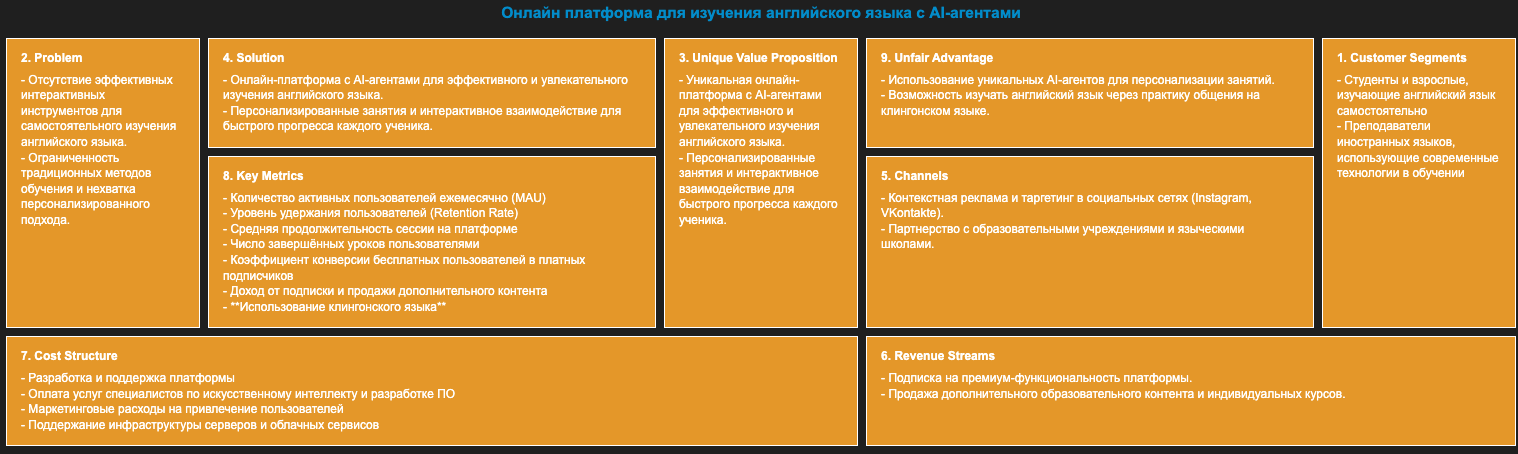